Assignment 2

Import Libraries

In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR, ExponentialLR

Load the Dataset

In [2]:
# define a sequence of data transformations that will be applied to the dataset
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.EMNIST(root='./data', split='balanced', train=True, transform=transform, download=True)
test_dataset = datasets.EMNIST(root='./data', split='balanced', train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [3]:
# print the number of training samples in the datasets
print(f'Training samples:{len(train_dataset)}')
# print the number of testing samples in the datasets
print(f'Testing samples:{len(test_dataset)}')

Training samples:112800
Testing samples:18800


Visualize the EMNIST Dataset

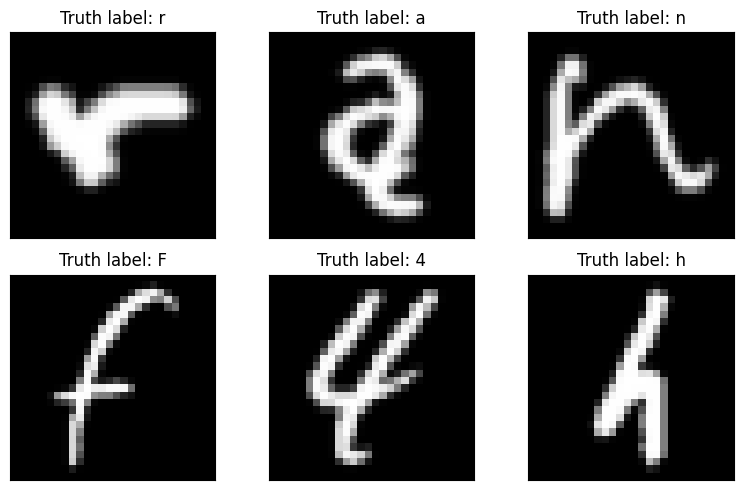

In [24]:
# load EMNIST train dataset and create data loader
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=6)
# get first batch of images and labels from data loader
x_train, y_train = next(iter(train_loader))

# load mapping file
mapping = pd.read_csv("emnist-balanced-mapping.txt", sep=" ", header=None)
mapping_dict = {int(key): chr(value) for key, value in zip(mapping[0], mapping[1])}

# plot images and labels
# create figure and subplots for displaying images and labels
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(8, 5))
for i, ax in enumerate(axes.flat):
    # reshape image data
    img = x_train[i].reshape((28, 28))
    # rotate image 90 degrees clockwise
    img = np.rot90(img)
    # flip image vertically
    img = np.flipud(img)
    # display image on subplot
    ax.imshow(img, cmap="gray")
    # get corresponding label name
    label = mapping_dict[int(y_train[i])]
    # set subplot title to label name
    ax.set_title("Truth label: {}".format(label))
    # remove x-axis ticks from subplot
    ax.set_xticks([])
    # remove y-axis ticks from subplot
    ax.set_yticks([])
# automatically adjust subplot parameters to fit figure area
plt.tight_layout()
# display figure
plt.show()

CNN Model Building

In [4]:
# define the MLP

class MLP(nn.Module):
    # define the __init__ function, which is executed when initializing the object
    def __init__(self, activation, batch_norm, dropout):
        # call the __init__ function of the superclass to initialize the object
        super(MLP, self).__init__()
        # define a fully connected layer with 784 input neurons and 512 output neurons
        self.fc1 = nn.Linear(784, 512)
        # define a batch normalization layer for the previous fully connected layer, if batch_norm is True
        self.bn1 = nn.BatchNorm1d(512) if batch_norm else None
        # define an activation function (e.g. ReLU) for the previous batch normalization layer
        self.activation1 = activation()
        # define a dropout layer for the previous activation function, if dropout is True
        self.dropout1 = nn.Dropout(0.2) if dropout else None
        
        # define a fully connected layer with 512 input neurons and 256 output neurons
        self.fc2 = nn.Linear(512, 256)
        # define a batch normalization layer for the previous fully connected layer, if batch_norm is True
        self.bn2 = nn.BatchNorm1d(256) if batch_norm else None
        # define an activation function (e.g. ReLU) for the previous batch normalization layer
        self.activation2 = activation()
        # define a dropout layer for the previous activation function, if dropout is True
        self.dropout2 = nn.Dropout(0.2) if dropout else None
        
        # define a fully connected layer with 256 input neurons and 128 output neurons
        self.fc3 = nn.Linear(256, 128)
        # define a batch normalization layer for the previous fully connected layer, if batch_norm is True
        self.bn3 = nn.BatchNorm1d(128) if batch_norm else None
        # define an activation function (e.g. ReLU) for the previous batch normalization layer
        self.activation3 = activation()
        # define a dropout layer for the previous activation function, if dropout is True
        self.dropout3 = nn.Dropout(0.2) if dropout else None
        
        # define a fully connected layer with 128 input neurons and 47 output neurons
        self.fc4 = nn.Linear(128, 47)
    
    # define the forward function, which specifies how the input is transformed into the output
    def forward(self, x):
        # reshape the input tensor to have a shape of (-1, 784), where -1 means the batch size is inferred automatically
        x = x.view(-1, 784)
        
        # pass the input through the first fully connected layer
        x = self.fc1(x)
        # pass the output through the batch normalization layer, if it is defined
        if self.bn1:
            x = self.bn1(x)
        # pass the output through the activation function
        x = self.activation1(x)
        # pass the output through the dropout layer, if it is defined
        if self.dropout1:
            x = self.dropout1(x)
        
        # repeat the same process for the next two fully connected layers
        
        x = self.fc2(x)
        if self.bn2:
            x = self.bn2(x)
        x = self.activation2(x)
        if self.dropout2:
            x = self.dropout2(x)

        x = self.fc3(x)
        if self.bn3:
            x = self.bn3(x)
        x = self.activation3(x)
        if self.dropout3:
            x = self.dropout3(x)
            
        x = self.fc4(x)
        
        return x

In [26]:
def cross_validation(model, optimizer, scheduler=None, regularization=None, reg_lambda=0.001):
    # check if a GPU is available and moves the model to the GPU if it is avaiable
    if torch.cuda.is_available():
        # pass the model to cuda
        model = model.cuda()
    # set the number of epochsthe  
    epochs = 10
    # set the number of folds to use in k-fold cross-validation
    n_splits = 5
    
    # create a KFold object with n_splits folds and shuffles the data before splitting
    kfold = KFold(n_splits=n_splits, shuffle=True)
    
    # generate the training and validation indices
    for index, (train_idx, val_idx) in enumerate(kfold.split(train_dataset)):
        train_subset = torch.utils.data.Subset(train_dataset, train_idx)
        val_subset = torch.utils.data.Subset(train_dataset, val_idx)

        training_loader = DataLoader(train_subset, batch_size=64, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=64, shuffle=False)
        
        avg_accuracy = 0

        # train the model
        for epoch in range(epochs):
            # set the model in training mode
            model.train()
            total_loss = 0
            # loop through the training data
            for item in training_loader:
                data, target = item
                if torch.cuda.is_available():  
                    data = data.cuda()
                    target = target.cuda()
                # zero the gradients
                optimizer.zero_grad()
                # forward pass
                output = model(data)
                # compute the loss
                loss = nn.CrossEntropyLoss()(output, target)
                if torch.cuda.is_available():
                    loss = loss.cuda()
                # apply regularization, if specified
                if regularization == 'L1':
                    l1_norm = sum(p.abs().sum() for p in model.parameters() if len(p.size()) > 1)
                    loss += reg_lambda * l1_norm
                elif regularization == 'L2':
                    l2_norm = sum(p.pow(2).sum() for p in model.parameters() if len(p.size()) > 1)
                    loss += reg_lambda * l2_norm
                # backpropagation
                loss.backward()
                optimizer.step()
                # accumulate the loss
                total_loss += loss.item()
            # if a scheduler is specified, adjust the learning rate
            if scheduler:
                scheduler.step()

            # validate the model
            # set the model in evaluation mode
            model.eval()
            correct = 0
            total = 0
            with torch.no_grad():
                # loop through the validation data
                for data, target in val_loader:
                    if torch.cuda.is_available():
                        data = data.cuda()
                        target = target.cuda()
                    # forward pass
                    output = model(data)
                    # compute the predicted class
                    _, predicted = torch.max(output.data, 1)
                    # accumulate the number of correct predictions
                    total += target.size(0)
                    correct += (predicted == target).sum().item()
            # compute the accuracy and loss
            accuracy = 100 * correct / total
            loss = total_loss / len(training_loader)
            # print the epoch, fold, loss, and accuracy
            print('Epoch [{}/{}], fold:{}, Loss: {} Accuracy: {:.2f}%'.format(epoch+1, 10, index + 1, loss, accuracy))
            
        avg_accuracy += accuracy

    avg_accuracy /= n_splits
            
    return avg_accuracy

In [27]:
# generate lists of different options for the hyperparameters
learning_rate_schedulers = [StepLR, ExponentialLR]
activation_functions = [nn.ReLU, nn.LeakyReLU, nn.ELU]
optimizers = [optim.SGD, optim.Adam, optim.RMSprop]
batch_norm_options = [True, False]
regularizations = ['none', 'L1', 'L2']
dropout_options = [True, False]

# radomly select one from the hyperparameters lists as the best hyperparameters respectively
best_lr_scheduler = StepLR
best_activation = nn.ReLU
best_optimizer = optim.SGD
best_batch_norm = False
best_regularization = 'none'
best_dropout = False

# set initial value of the best accuracy
best_accuracy = 0

In [5]:
def scheduler_type(best_lr_scheduler, optimizer):
    # selects the appropriate learning rate scheduler based on the best_lr_scheduler argument
    if best_lr_scheduler == StepLR:
        # create a StepLR scheduler with a step size of 1 and gamma of 0.95
        scheduler = best_lr_scheduler(optimizer, step_size=1, gamma=0.95)
    elif best_lr_scheduler == ExponentialLR:
        # create an ExponentialLR scheduler with a gamma of 0.95
        scheduler = best_lr_scheduler(optimizer, gamma=0.95)
    else:
        # Raise an error for an unsupported learning rate scheduler
        raise ValueError(f"Incorrect option of scheduler: {best_lr_scheduler}")
    
    return scheduler

In [29]:
# loop over each learning rate scheduler
for lr_scheduler in learning_rate_schedulers:
    # create a new model with the best hyperparameters
    model = MLP(activation=best_activation, batch_norm=best_batch_norm, dropout=best_dropout)
    # create a new optimizer with the best hyperparameters
    optimizer = best_optimizer(model.parameters(), lr=0.001)

    # pass the correct parameters for each scheduler type
    scheduler = scheduler_type(best_lr_scheduler, optimizer)
    print(f"Analyzing performance of lr_scheduler type: {lr_scheduler.__name__}")
    accuracy = cross_validation(model, optimizer, scheduler)
    
    # update the lr_scheduler and accracy if the current lr_scheduler yields a higher accuracy
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_lr_scheduler = lr_scheduler
# print the result with the best accuracy
print(f"Best learning rate scheduler: {lr_scheduler.__name__}")

Analyzing performance of lr_scheduler type: StepLR
Epoch [1/10], fold:1, Loss: 3.838866974783282 Accuracy: 5.46%
Epoch [2/10], fold:1, Loss: 3.80874459067135 Accuracy: 8.38%
Epoch [3/10], fold:1, Loss: 3.7617709727997477 Accuracy: 10.74%
Epoch [4/10], fold:1, Loss: 3.6785983340960025 Accuracy: 14.27%
Epoch [5/10], fold:1, Loss: 3.5283726611035937 Accuracy: 18.09%
Epoch [6/10], fold:1, Loss: 3.285263596189783 Accuracy: 28.32%
Epoch [7/10], fold:1, Loss: 2.9616084900308164 Accuracy: 36.38%
Epoch [8/10], fold:1, Loss: 2.609316809803036 Accuracy: 41.85%
Epoch [9/10], fold:1, Loss: 2.294523225439356 Accuracy: 46.37%
Epoch [10/10], fold:1, Loss: 2.0531302842688053 Accuracy: 49.46%
Epoch [1/10], fold:2, Loss: 1.8763698615926376 Accuracy: 52.41%
Epoch [2/10], fold:2, Loss: 1.7516123382757742 Accuracy: 54.39%
Epoch [3/10], fold:2, Loss: 1.660417761447582 Accuracy: 55.54%
Epoch [4/10], fold:2, Loss: 1.5917620263201124 Accuracy: 56.65%
Epoch [5/10], fold:2, Loss: 1.5382462301998274 Accuracy: 57.7

In [30]:
# loop over each activation function
for activation in activation_functions:
    # create a new model with the best hyperparameters
    model = MLP(activation=activation, batch_norm=best_batch_norm, dropout=best_dropout)
    # create a new optimizer with the best hyperparameters
    optimizer = best_optimizer(model.parameters(), lr=0.001)

    # pass the correct parameters for each scheduler type
    scheduler = scheduler_type(ExponentialLR, optimizer)
    print(f"Analyzing performance of activation function: {activation.__name__}")
    accuracy = cross_validation(model, optimizer, scheduler)
    # update activation function and accracy if the current lr_scheduler yields a higher accuracy
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_activation = activation
# print the result with the best accuracy
print(f"Best activation function: {best_activation}")

Analyzing performance of activation function: ReLU
Epoch [1/10], fold:1, Loss: 3.844580626656823 Accuracy: 4.68%
Epoch [2/10], fold:1, Loss: 3.8228110545070457 Accuracy: 7.78%
Epoch [3/10], fold:1, Loss: 3.790217270580589 Accuracy: 10.11%
Epoch [4/10], fold:1, Loss: 3.7329491743804715 Accuracy: 11.98%
Epoch [5/10], fold:1, Loss: 3.6261667676005804 Accuracy: 15.20%
Epoch [6/10], fold:1, Loss: 3.4415147101625485 Accuracy: 20.51%
Epoch [7/10], fold:1, Loss: 3.170439663170077 Accuracy: 30.44%
Epoch [8/10], fold:1, Loss: 2.824775553764181 Accuracy: 38.13%
Epoch [9/10], fold:1, Loss: 2.467023398182916 Accuracy: 43.83%
Epoch [10/10], fold:1, Loss: 2.179829309764483 Accuracy: 47.84%
Epoch [1/10], fold:2, Loss: 1.982032404808288 Accuracy: 51.06%
Epoch [2/10], fold:2, Loss: 1.841907800089383 Accuracy: 53.03%
Epoch [3/10], fold:2, Loss: 1.7395096532841947 Accuracy: 54.81%
Epoch [4/10], fold:2, Loss: 1.6605151948353922 Accuracy: 55.95%
Epoch [5/10], fold:2, Loss: 1.5981297229198699 Accuracy: 56.84

In [31]:
# loop over each optimizer
for opt in optimizers:
    # create a new model with the best hyperparameters
    model = MLP(activation=best_activation, batch_norm=best_batch_norm, dropout=best_dropout)
    # create a new optimizer with the best hyperparameters
    optimizer = opt(model.parameters(), lr=0.001)
    # pass the correct parameters for each scheduler type
    scheduler = scheduler_type(best_lr_scheduler, optimizer)
    print(f"Analyzing performance of optimizer: {opt.__name__}")
    accuracy = cross_validation(model, optimizer, scheduler)
    # update the optinizer and accracy if the current lr_scheduler yields a higher accuracy
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_optimizer = opt
# print the result with the best accuracy
print(f"Best optimizer: {best_optimizer}")

Analyzing performance of optimizer: SGD
Epoch [1/10], fold:1, Loss: 3.7597641741975827 Accuracy: 20.12%
Epoch [2/10], fold:1, Loss: 3.5284504286786342 Accuracy: 28.99%
Epoch [3/10], fold:1, Loss: 3.17027327338009 Accuracy: 33.25%
Epoch [4/10], fold:1, Loss: 2.713385429619052 Accuracy: 41.07%
Epoch [5/10], fold:1, Loss: 2.282407355393078 Accuracy: 48.51%
Epoch [6/10], fold:1, Loss: 1.969208659347913 Accuracy: 52.05%
Epoch [7/10], fold:1, Loss: 1.7740628457238488 Accuracy: 54.44%
Epoch [8/10], fold:1, Loss: 1.6510845574926822 Accuracy: 55.97%
Epoch [9/10], fold:1, Loss: 1.5682085559723224 Accuracy: 57.28%
Epoch [10/10], fold:1, Loss: 1.5080452506423843 Accuracy: 58.19%
Epoch [1/10], fold:2, Loss: 1.4648520280283392 Accuracy: 59.54%
Epoch [2/10], fold:2, Loss: 1.4272219257151826 Accuracy: 60.28%
Epoch [3/10], fold:2, Loss: 1.3965006944135572 Accuracy: 60.78%
Epoch [4/10], fold:2, Loss: 1.3707202564317285 Accuracy: 61.35%
Epoch [5/10], fold:2, Loss: 1.3485559246641525 Accuracy: 61.81%
Epoc

In [32]:
# loop over each batch normaliztion option
for batch_norm in batch_norm_options:
    # create a new model with the best hyperparameters
    model = MLP(activation=best_activation, batch_norm=batch_norm, dropout=best_dropout)
    # create a new optimizer with the best hyperparameters
    optimizer = best_optimizer(model.parameters(), lr=0.001)
    # pass the correct parameters for each scheduler type
    scheduler = scheduler_type(best_lr_scheduler, optimizer)
    print(f"Analyzing performance of batch_norm: {batch_norm}")
    accuracy = cross_validation(model, optimizer, scheduler)
    # update the batch normaliztion option and accracy if the current lr_scheduler yields a higher accuracy
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_batch_norm = batch_norm
# print the result with the best accuracy
print(f"Best batch normalization option: {best_batch_norm}")

Analyzing performance of batch_norm: True
Epoch [1/10], fold:1, Loss: 0.9752241151764037 Accuracy: 78.98%
Epoch [2/10], fold:1, Loss: 0.6044656235064175 Accuracy: 81.85%
Epoch [3/10], fold:1, Loss: 0.5161286860915786 Accuracy: 82.85%
Epoch [4/10], fold:1, Loss: 0.46395012963536786 Accuracy: 84.14%
Epoch [5/10], fold:1, Loss: 0.42460792361633154 Accuracy: 84.06%
Epoch [6/10], fold:1, Loss: 0.3905218296545617 Accuracy: 84.09%
Epoch [7/10], fold:1, Loss: 0.36536221310284966 Accuracy: 84.93%
Epoch [8/10], fold:1, Loss: 0.3446621801677748 Accuracy: 85.31%
Epoch [9/10], fold:1, Loss: 0.32256820513635664 Accuracy: 85.38%
Epoch [10/10], fold:1, Loss: 0.3039403327284975 Accuracy: 85.65%
Epoch [1/10], fold:2, Loss: 0.3331733014355315 Accuracy: 89.55%
Epoch [2/10], fold:2, Loss: 0.30488124815813195 Accuracy: 89.09%
Epoch [3/10], fold:2, Loss: 0.2880610627326982 Accuracy: 89.54%
Epoch [4/10], fold:2, Loss: 0.2714797979656686 Accuracy: 88.95%
Epoch [5/10], fold:2, Loss: 0.25718182563676056 Accuracy

In [33]:
# loop over each regularization option
for reg in regularizations:
    # create a new model with the best hyperparameters
    model = MLP(activation=best_activation, batch_norm=best_batch_norm, dropout=best_dropout)
    # create a new optimizer with the best hyperparameters
    optimizer = best_optimizer(model.parameters(), lr=0.001)
    # pass the correct parameters for each scheduler type
    scheduler = scheduler_type(best_lr_scheduler, optimizer)
    print(f"Analyzing performance of regularization: {reg}")
    accuracy = cross_validation(model, optimizer, scheduler, regularization=reg)
    # update the regularization option and accracy if the current lr_scheduler yields a higher accuracy
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_regularization = reg
# print the result with the best accuracy
print(f"Best regularization: {best_regularization}")

Analyzing performance of regularization: none
Epoch [1/10], fold:1, Loss: 0.8427190969599054 Accuracy: 80.71%
Epoch [2/10], fold:1, Loss: 0.5043275099802524 Accuracy: 82.59%
Epoch [3/10], fold:1, Loss: 0.41912550436900864 Accuracy: 82.76%
Epoch [4/10], fold:1, Loss: 0.36340785613085363 Accuracy: 83.70%
Epoch [5/10], fold:1, Loss: 0.3217878083652216 Accuracy: 83.94%
Epoch [6/10], fold:1, Loss: 0.28495691283903224 Accuracy: 84.14%
Epoch [7/10], fold:1, Loss: 0.25716911246801943 Accuracy: 84.88%
Epoch [8/10], fold:1, Loss: 0.22860502066183175 Accuracy: 85.03%
Epoch [9/10], fold:1, Loss: 0.20678417088979104 Accuracy: 84.55%
Epoch [10/10], fold:1, Loss: 0.19323020914292083 Accuracy: 84.42%
Epoch [1/10], fold:2, Loss: 0.27757748258134995 Accuracy: 92.07%
Epoch [2/10], fold:2, Loss: 0.20515258254100244 Accuracy: 91.26%
Epoch [3/10], fold:2, Loss: 0.17955145666785274 Accuracy: 91.49%
Epoch [4/10], fold:2, Loss: 0.16055479648899526 Accuracy: 91.19%
Epoch [5/10], fold:2, Loss: 0.1452366363640267

In [34]:
# loop over each drop out option
for dropout in dropout_options:
    # create a new model with the best hyperparameters
    model = MLP(activation=best_activation, batch_norm=best_batch_norm, dropout=dropout)
    # create a new optimizer with the best hyperparameters
    optimizer = best_optimizer(model.parameters(), lr=0.001)
    # pass the correct parameters for each scheduler type
    scheduler = scheduler_type(best_lr_scheduler, optimizer)
    print(f"Analyzing performance of dropout: {dropout}")
    accuracy = cross_validation(model, optimizer, scheduler)
    # update the drop out option and accracy if the current lr_scheduler yields a higher accuracy
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_dropout = dropout
# print the result with the best accuracy
print(f"Best dropout option: {best_dropout}")

Analyzing performance of dropout: True
Epoch [1/10], fold:1, Loss: 1.0129305682072403 Accuracy: 79.85%
Epoch [2/10], fold:1, Loss: 0.6504199048517444 Accuracy: 81.88%
Epoch [3/10], fold:1, Loss: 0.5667484002016114 Accuracy: 83.05%
Epoch [4/10], fold:1, Loss: 0.5157522522494302 Accuracy: 84.23%
Epoch [5/10], fold:1, Loss: 0.48289214288089294 Accuracy: 84.66%
Epoch [6/10], fold:1, Loss: 0.45684775404684935 Accuracy: 83.95%
Epoch [7/10], fold:1, Loss: 0.43572941360110085 Accuracy: 85.30%
Epoch [8/10], fold:1, Loss: 0.41193133191542425 Accuracy: 85.31%
Epoch [9/10], fold:1, Loss: 0.3946375767442774 Accuracy: 85.85%
Epoch [10/10], fold:1, Loss: 0.380858069742825 Accuracy: 85.31%
Epoch [1/10], fold:2, Loss: 0.4084243915182479 Accuracy: 89.04%
Epoch [2/10], fold:2, Loss: 0.3783354441694757 Accuracy: 89.24%
Epoch [3/10], fold:2, Loss: 0.36511372505350315 Accuracy: 88.84%
Epoch [4/10], fold:2, Loss: 0.3507057133190175 Accuracy: 88.86%
Epoch [5/10], fold:2, Loss: 0.33709833123688154 Accuracy: 88

In [16]:
# best choice of model MLP
best_lr_scheduler = ExponentialLR
best_activation = nn.ELU
best_optimizer = optim.Adam
best_batch_norm = False
best_regularization = 'none'
best_dropout = False

best_accuracy = 0

In [7]:
def training_process(model, optimizer, scheduler=None, regularization=None, reg_lambda=0.001, num_epochs=15):
    # move the model to GPU if available
    if torch.cuda.is_available():
        model = model.cuda()
    # initialize empty lists to store losses and accuracies for each epoch
    losses = []
    accuracies = []

    # train the model
    for epoch in range(num_epochs):
        # set the model in training mode
        model.train()
        total_loss = 0.0
        correct = 0
        total = 0
        # iterate through the batches of data and lables in the train_loader
        for data, target in train_loader:
            if torch.cuda.is_available():
                # move the data and target to GPU if available
                data = data.cuda()
                target = target.cuda()
            # set the gradients to zero
            optimizer.zero_grad()
            # forward pass
            output = model(data)
            # calculate the loss
            loss = nn.CrossEntropyLoss()(output, target)
            if torch.cuda.is_available():
                loss = loss.cuda()
            # add regularization if specified
            if regularization == 'L1':
                l1_norm = sum(p.abs().sum() for p in model.parameters() if len(p.size()) > 1)
                loss += reg_lambda * l1_norm
            elif regularization == 'L2':
                l2_norm = sum(p.pow(2).sum() for p in model.parameters() if len(p.size()) > 1)
                loss += reg_lambda * l2_norm
            # backward pass
            loss.backward()
            # update the weights
            optimizer.step()
            # calculate the total loss
            total_loss += loss.item()
            # calculate the number of correct predictions
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
        # if a scheduler is specified, update the learning rate
        if scheduler:
            scheduler.step()
        # calculate the accuracy for the current epoch
        accuracy = 100 * correct / total
        # append the loss and accuracy to their respective lists
        losses.append(total_loss / len(train_loader))
        accuracies.append(accuracy)

    return losses, accuracies

In [34]:
def plot_graph(losses, accuracies, model_name):
    # plot the loss function graph of MLP model 
    plt.plot(losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Function Value of ' + model_name)
    plt.show()

    # plot the accuracy graph of MLP model
    plt.plot(accuracies)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy of ' + model_name)
    plt.show()

In [41]:
def plot_confusion_matrix(cm, idx_to_class, model_name):
    # plot the confusion matrix
    plt.figure(figsize=(25, 25))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=idx_to_class.values(), yticklabels=idx_to_class.values())
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix Of ' + model_name)
    plt.show()

In [10]:
def generate_confusion_matrix_and_labels(model, test_loader):
    # check if CUDA is available
    if torch.cuda.is_available():
        model = model.cuda()
    # create empty lists to store true and predicted labels
    true_labels = []
    predicted_labels = []
    # put the model in evaluation mode
    model.eval()
    # turn off gradient computation to save memory and time
    with torch.no_grad():
        # iterate through the test data loader
        for images, labels in test_loader:
            # move the images to the GPU, if available
            if torch.cuda.is_available():
                images = images.cuda()
            # forward pass through the model
            outputs = model(images)
            # get the predicted labels by taking the index of the max value in the output tensor
            _, preds = torch.max(outputs.data, 1)
            # move the predicted labels to the CPU and convert to numpy array, then add to the list of predicted labels
            preds = preds.cpu()
            # convert the true labels to numpy array and add to the list of true labels
            true_labels.extend(labels.numpy().tolist())
            # convert the true labels to numpy array and add to the list of true labels
            predicted_labels.extend(preds.numpy().tolist())
    # compute the confusion matrix using the true and predicted labels
    cm = confusion_matrix(true_labels, predicted_labels)
    
    return cm, true_labels, predicted_labels

In [43]:
model = MLP(activation=best_activation, batch_norm=best_batch_norm, dropout=best_dropout)
optimizer = best_optimizer(model.parameters(), lr=0.001)

# pass the correct parameters for each scheduler type
scheduler = scheduler_type(best_lr_scheduler, optimizer)
# record the start time
start_time = time.time()  
losses, accuracies = training_process(model, optimizer, scheduler, best_regularization)
# record the end time
end_time = time.time()
# calculate the training time
training_time = end_time - start_time

In [44]:
# print the training time
print(f"Training time: {training_time:.2f} seconds")

Training time: 436.21 seconds


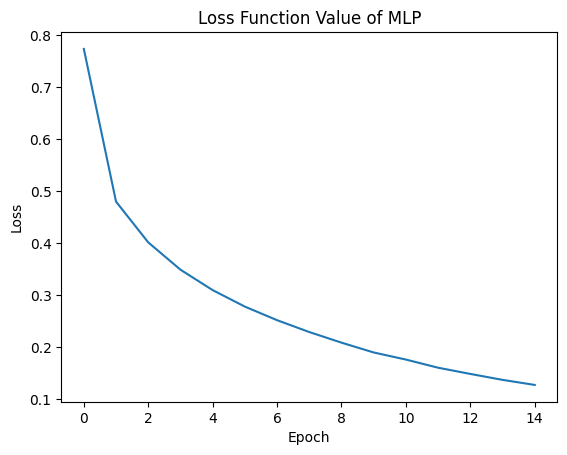

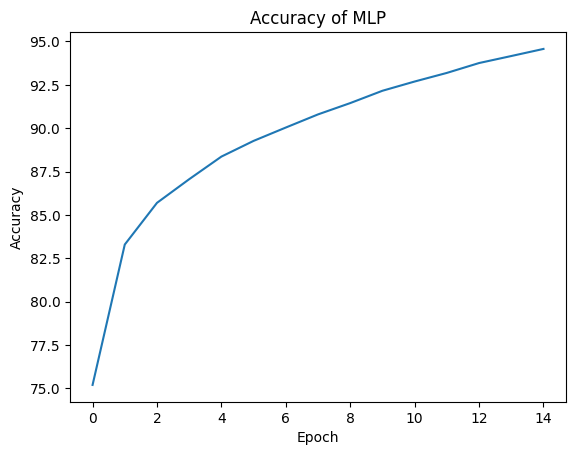

In [45]:
# plot loss function graph and accuracy graph
plot_graph(losses, accuracies, 'MLP')

In [20]:
def display_image(image, title, position):
    # move to CPU and convert to numpy
    image = image.cpu().squeeze().numpy()
    # rotate the image 90 degrees
    image = np.rot90(image)
    # flip the image vertically
    image = np.flipud(image)
    plt.subplot(2, 3, position)
    plt.imshow(image, cmap='gray')
    plt.title(title)
    plt.axis('off')

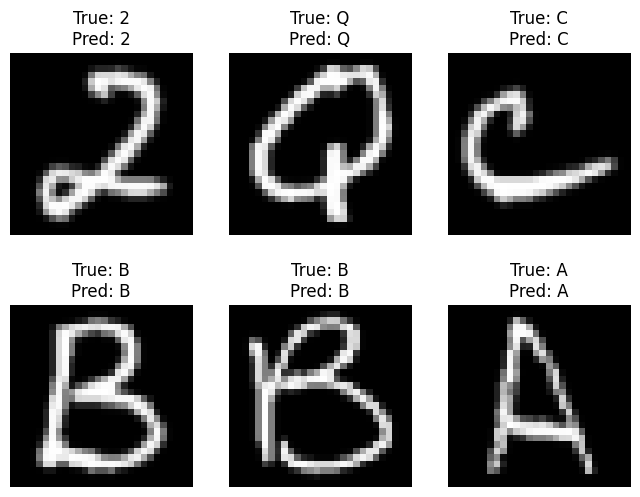

In [22]:
# create a DataLoader for the test dataset with a batch size of 6 and shuffle the data
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=True)
# get the first batch of images and labels from the test loader
images, labels = next(iter(test_loader))

# send the data to the GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
images = images.to(device)

# predict the labels using the MLP model
model.eval()
# disable gradient calculation since we're not training the model
with torch.no_grad():
    # make predictions on the test batch
    outputs = model(images)
    _, predicted_labels = torch.max(outputs.data, 1)

# map class indices to class names
idx_to_class = {v: k for k, v in test_dataset.class_to_idx.items()}

# display the true and predicted labels for the top six samples
plt.figure(figsize=(8, 6))
for i in range(6):
    # get the true and predicted labels for the i-th sample
    true_label = idx_to_class[labels[i].item()]
    predicted_label = idx_to_class[predicted_labels[i].item()]
    # display the image and its true and predicted labels
    display_image(images[i], f"True: {true_label}\nPred: {predicted_label}", i + 1)

plt.show()

In [23]:
# get the result for generating the matrix and classification report
cm, true_labels, predicted_labels = generate_confusion_matrix_and_labels(model, test_loader)

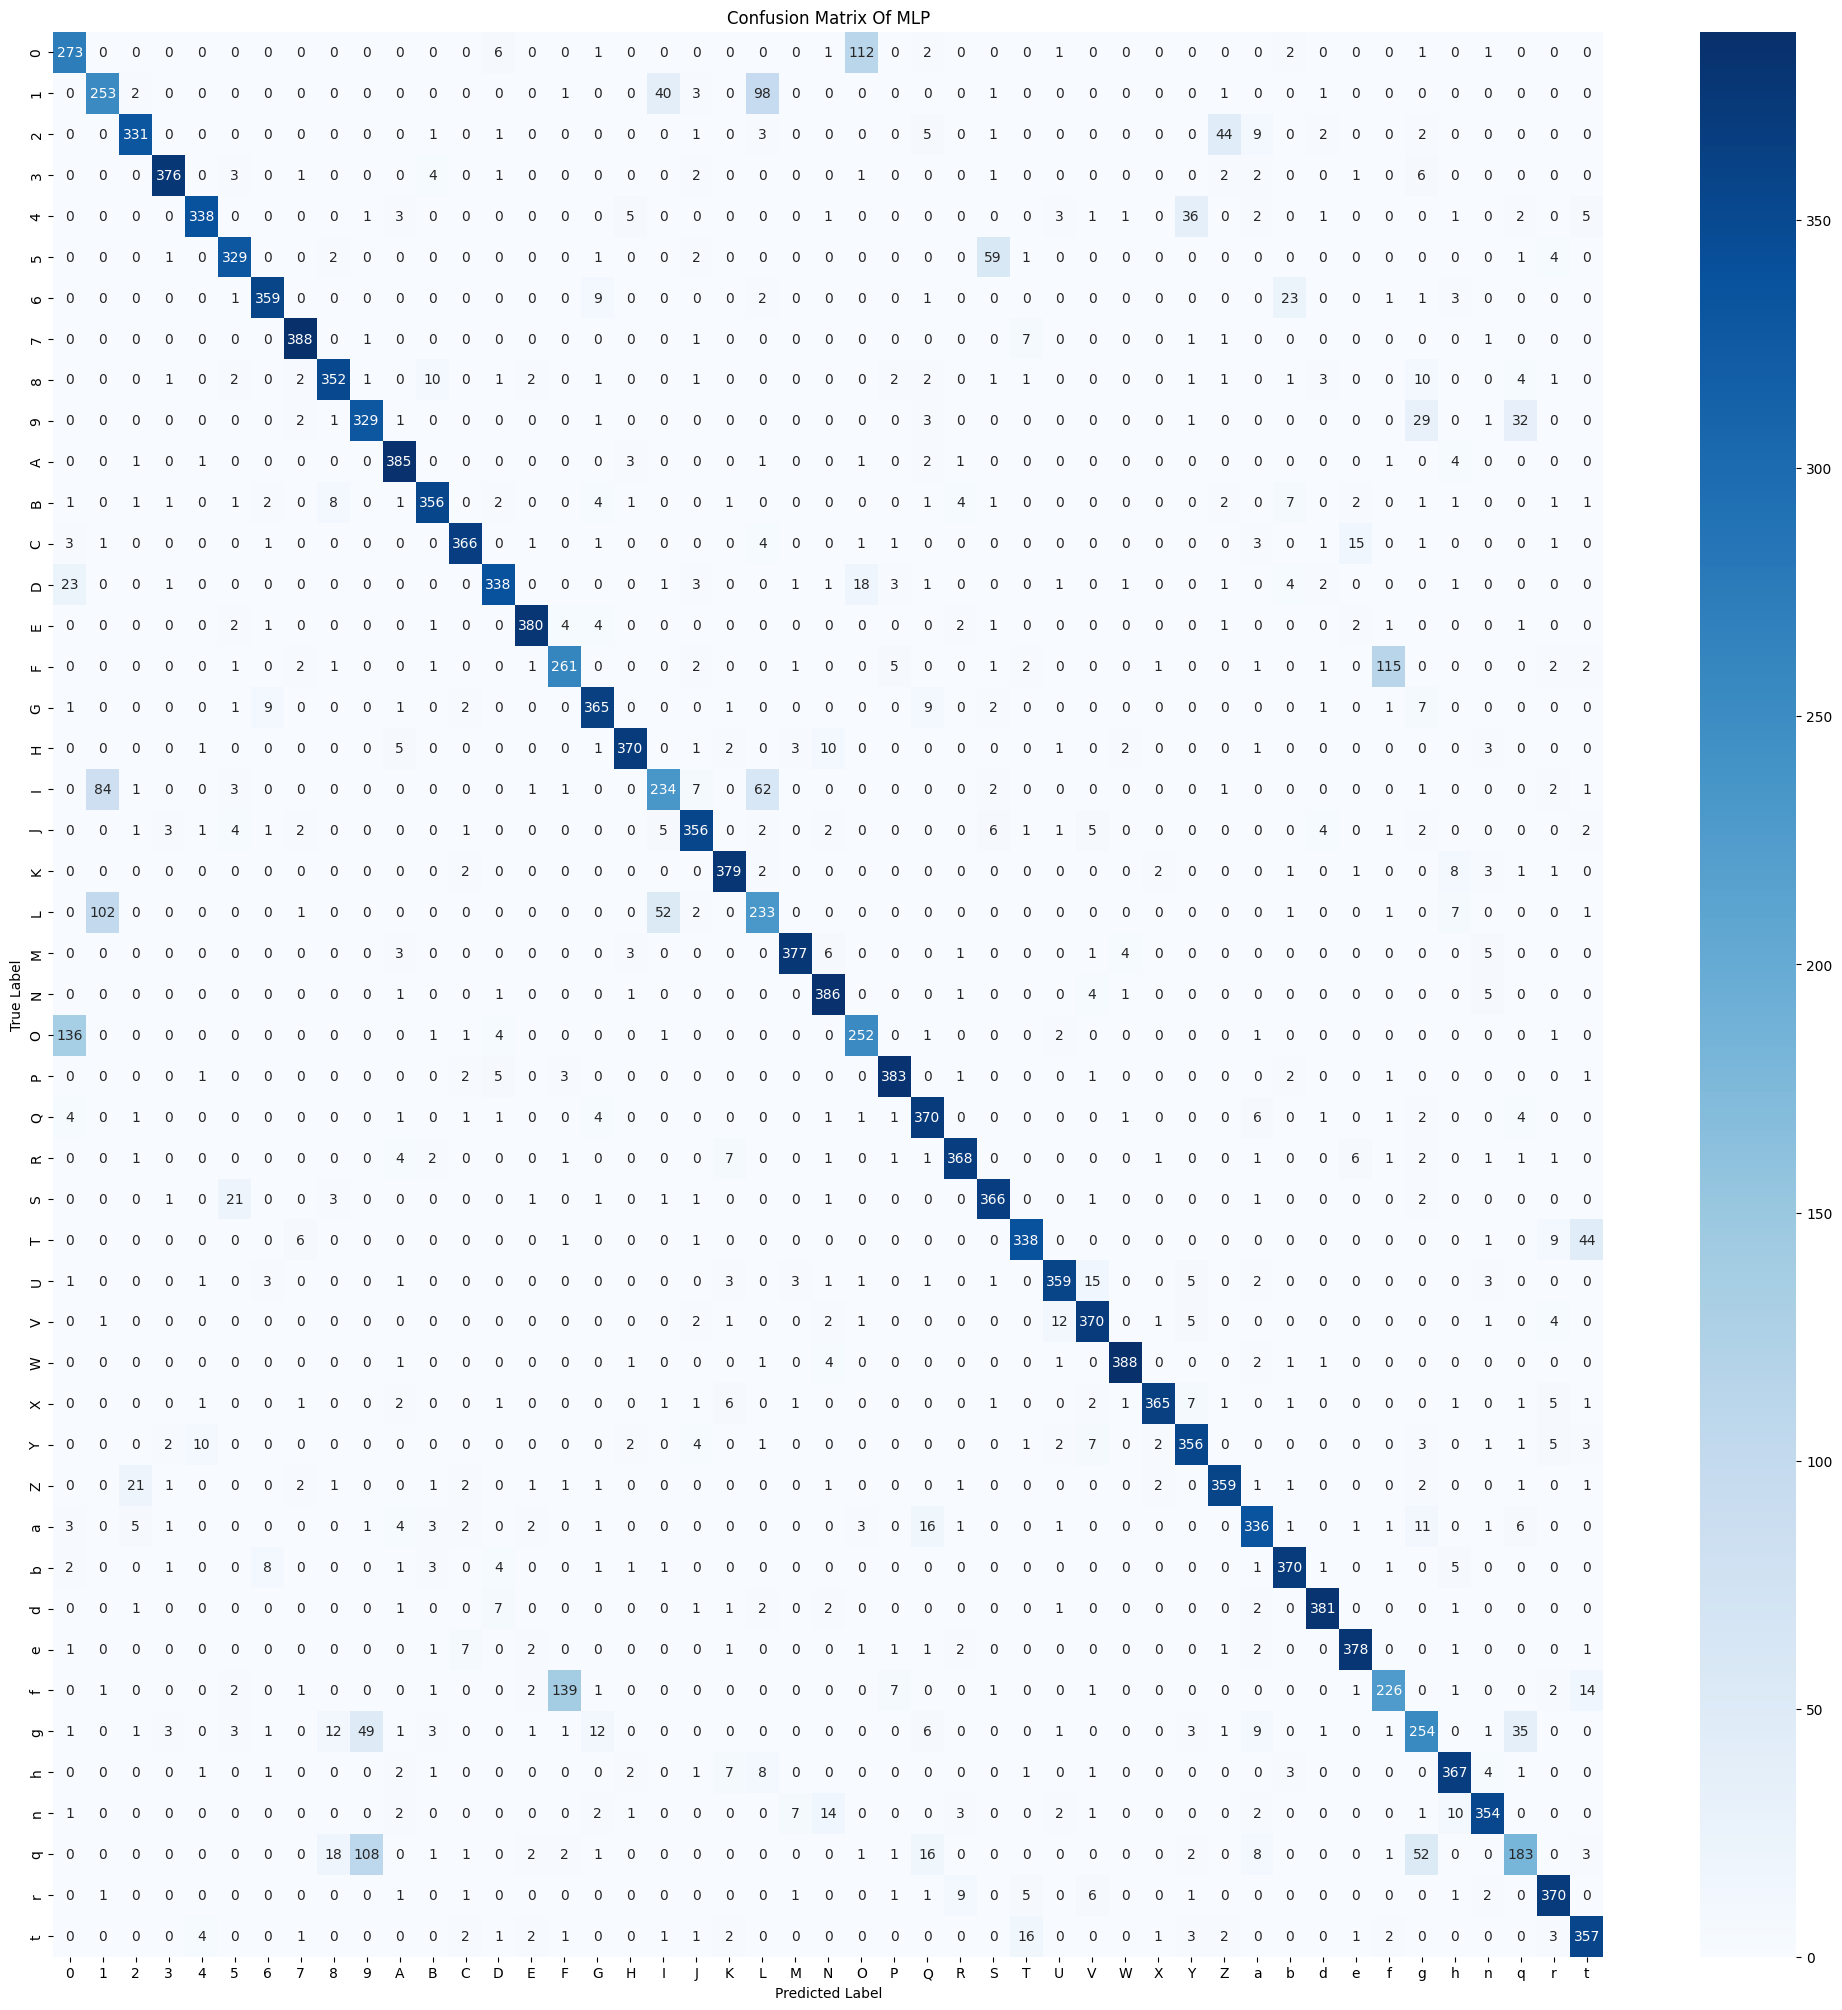

In [24]:
# plot confusion matrix
plot_confusion_matrix(cm, idx_to_class, 'MLP')

In [25]:
# generate the classification report
report = classification_report(true_labels, predicted_labels, target_names=idx_to_class.values())

# print the classification report od MLP model
print(report)

              precision    recall  f1-score   support

           0       0.61      0.68      0.64       400
           1       0.57      0.63      0.60       400
           2       0.90      0.83      0.86       400
           3       0.96      0.94      0.95       400
           4       0.94      0.84      0.89       400
           5       0.88      0.82      0.85       400
           6       0.93      0.90      0.91       400
           7       0.95      0.97      0.96       400
           8       0.88      0.88      0.88       400
           9       0.67      0.82      0.74       400
           A       0.91      0.96      0.94       400
           B       0.91      0.89      0.90       400
           C       0.94      0.92      0.93       400
           D       0.91      0.84      0.87       400
           E       0.95      0.95      0.95       400
           F       0.63      0.65      0.64       400
           G       0.89      0.91      0.90       400
           H       0.95    

In [30]:
class CNN(nn.Module):
    def __init__(self, activation, batch_norm, dropout):
        # call the init method of the parent class
        super(CNN, self).__init__()
        # first convolutional layer with 32 filters, kernel size of 3x3, and padding of 1
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        # batch normalization layer for conv1, if batch_norm is True
        self.bn1 = nn.BatchNorm2d(32) if batch_norm else None
        # activation function for conv1
        self.activation1 = activation()
        # max pooling layer with kernel size of 2x2 and stride of 2
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # second convolutional layer with 64 filters, kernel size of 3x3, and padding of 1
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        # batch normalization layer for conv2, if batch_norm is True
        self.bn2 = nn.BatchNorm2d(64) if batch_norm else None
        # activation function for conv2
        self.activation2 = activation()
        # max pooling layer with kernel size of 2x2 and stride of 2
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # first fully connected layer with 256 output features
        self.fc1 = nn.Linear(64 * 7 * 7, 256)
        # batch normalization layer for fc1, if batch_norm is True
        self.bn3 = nn.BatchNorm1d(256) if batch_norm else None
        # activation function for fc1
        self.activation3 = activation()
        # dropout layer with a dropout rate of 0.2, if dropout is True
        self.dropout1 = nn.Dropout(0.2) if dropout else None
        
        # second fully connected layer with 47 output features, corresponding to the number of classes
        self.fc2 = nn.Linear(256, 47)

    def forward(self, x):
        # forward pass through the layers of the neural network
        x = self.conv1(x)
        if self.bn1:
            x = self.bn1(x)
        x = self.activation1(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        if self.bn2:
            x = self.bn2(x)
        x = self.activation2(x)
        x = self.pool2(x)
        
        x = x.view(-1, 64 * 7 * 7)
        x = self.fc1(x)
        if self.bn3:
            x = self.bn3(x)
        x = self.activation3(x)
        if self.dropout1:
            x = self.dropout1(x)
        
        x = self.fc2(x)
        return x

In [36]:
# generate lists of different options for the hyperparameters
learning_rate_schedulers = [StepLR, ExponentialLR]
activation_functions = [nn.ReLU, nn.LeakyReLU, nn.ELU]
optimizers = [optim.SGD, optim.Adam, optim.RMSprop]
batch_norm_options = [True, False]
regularizations = ['none', 'L1', 'L2']
dropout_options = [True, False]

# Radomly select one from the hyperparameters lists as the best hyperparameters respectively
best_lr_scheduler = StepLR
best_activation = nn.ReLU
best_optimizer = optim.SGD
best_batch_norm = False
best_regularization = 'none'
best_dropout = False

# set initial value of the best accuracy
best_accuracy = 0

In [37]:
for lr_scheduler in learning_rate_schedulers:
    model = MLP(activation=best_activation, batch_norm=best_batch_norm, dropout=best_dropout)
    optimizer = best_optimizer(model.parameters(), lr=0.001)

    # Pass the correct parameters for each scheduler type
    
    scheduler = scheduler_type(best_lr_scheduler, optimizer)
    print(f"Analyzing performance of lr_scheduler type: {lr_scheduler.__name__}")
    accuracy = cross_validation(model, optimizer, scheduler)
    
    # Update the lr_scheduler and accracy if the current lr_scheduler yields a higher accuracy
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_lr_scheduler = lr_scheduler

print(f"Best learning rate scheduler: {lr_scheduler.__name__}")

Analyzing performance of lr_scheduler type: StepLR
Epoch [1/10], fold:1, Loss: 3.8397440920484827 Accuracy: 5.21%
Epoch [2/10], fold:1, Loss: 3.8113847166088455 Accuracy: 9.22%
Epoch [3/10], fold:1, Loss: 3.761852962920006 Accuracy: 12.09%
Epoch [4/10], fold:1, Loss: 3.663329565947783 Accuracy: 18.55%
Epoch [5/10], fold:1, Loss: 3.468560792875628 Accuracy: 23.82%
Epoch [6/10], fold:1, Loss: 3.146249522215931 Accuracy: 32.06%
Epoch [7/10], fold:1, Loss: 2.757495624799255 Accuracy: 39.73%
Epoch [8/10], fold:1, Loss: 2.3987037391527326 Accuracy: 44.36%
Epoch [9/10], fold:1, Loss: 2.126437038225485 Accuracy: 48.51%
Epoch [10/10], fold:1, Loss: 1.9384784507413282 Accuracy: 51.58%
Epoch [1/10], fold:2, Loss: 1.8048565246534685 Accuracy: 52.46%
Epoch [2/10], fold:2, Loss: 1.707548144438588 Accuracy: 54.17%
Epoch [3/10], fold:2, Loss: 1.6335091658517824 Accuracy: 55.40%
Epoch [4/10], fold:2, Loss: 1.5752407434984301 Accuracy: 56.71%
Epoch [5/10], fold:2, Loss: 1.5281652663616423 Accuracy: 57.7

In [38]:
for activation in activation_functions:
    model = MLP(activation=activation, batch_norm=best_batch_norm, dropout=best_dropout)
    optimizer = best_optimizer(model.parameters(), lr=0.001)

    
    scheduler = scheduler_type(ExponentialLR, optimizer)
    print(f"Analyzing performance of activation function: {activation.__name__}")
    accuracy = cross_validation(model, optimizer, scheduler)

    if accuracy > best_accuracy:
        
        best_accuracy = accuracy
        best_activation = activation

print(f"Best activation function: {best_activation}")

Analyzing performance of activation function: ReLU
Epoch [1/10], fold:1, Loss: 3.8366205112308474 Accuracy: 2.97%
Epoch [2/10], fold:1, Loss: 3.8022138066325626 Accuracy: 7.97%
Epoch [3/10], fold:1, Loss: 3.741611256667063 Accuracy: 14.62%
Epoch [4/10], fold:1, Loss: 3.623593085877439 Accuracy: 18.48%
Epoch [5/10], fold:1, Loss: 3.4000549275824365 Accuracy: 24.93%
Epoch [6/10], fold:1, Loss: 3.060277900459073 Accuracy: 33.63%
Epoch [7/10], fold:1, Loss: 2.698483929735549 Accuracy: 40.60%
Epoch [8/10], fold:1, Loss: 2.380520354517808 Accuracy: 45.08%
Epoch [9/10], fold:1, Loss: 2.120401340427128 Accuracy: 48.85%
Epoch [10/10], fold:1, Loss: 1.92776449783474 Accuracy: 51.84%
Epoch [1/10], fold:2, Loss: 1.7897977697088363 Accuracy: 53.43%
Epoch [2/10], fold:2, Loss: 1.6925219302481793 Accuracy: 54.97%
Epoch [3/10], fold:2, Loss: 1.620058534669538 Accuracy: 56.04%
Epoch [4/10], fold:2, Loss: 1.5639204705015142 Accuracy: 57.11%
Epoch [5/10], fold:2, Loss: 1.5188186465425695 Accuracy: 58.07%

In [39]:
for opt in optimizers:
    model = MLP(activation=best_activation, batch_norm=best_batch_norm, dropout=best_dropout)
    optimizer = opt(model.parameters(), lr=0.001)

    scheduler = scheduler_type(best_lr_scheduler, optimizer)
    print(f"Analyzing performance of optimizer: {opt.__name__}")
    accuracy = cross_validation(model, optimizer, scheduler)

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_optimizer = opt
    
print(f"Best optimizer: {best_optimizer}")

Analyzing performance of optimizer: SGD
Epoch [1/10], fold:1, Loss: 3.768534588475599 Accuracy: 18.52%
Epoch [2/10], fold:1, Loss: 3.5369357721179937 Accuracy: 23.25%
Epoch [3/10], fold:1, Loss: 3.188105364386917 Accuracy: 27.83%
Epoch [4/10], fold:1, Loss: 2.776891405869883 Accuracy: 38.75%
Epoch [5/10], fold:1, Loss: 2.381549793439554 Accuracy: 46.59%
Epoch [6/10], fold:1, Loss: 2.064170511140891 Accuracy: 50.57%
Epoch [7/10], fold:1, Loss: 1.8454006758142025 Accuracy: 53.22%
Epoch [8/10], fold:1, Loss: 1.701560656821474 Accuracy: 54.99%
Epoch [9/10], fold:1, Loss: 1.6027838420360647 Accuracy: 56.66%
Epoch [10/10], fold:1, Loss: 1.5314568857351938 Accuracy: 57.97%
Epoch [1/10], fold:2, Loss: 1.4807397073042308 Accuracy: 59.71%
Epoch [2/10], fold:2, Loss: 1.4380712999942455 Accuracy: 60.35%
Epoch [3/10], fold:2, Loss: 1.4037478374673966 Accuracy: 61.11%
Epoch [4/10], fold:2, Loss: 1.3754673568914968 Accuracy: 61.72%
Epoch [5/10], fold:2, Loss: 1.3515872957435906 Accuracy: 62.14%
Epoch

In [40]:
for batch_norm in batch_norm_options:
    model = MLP(activation=best_activation, batch_norm=batch_norm, dropout=best_dropout)
    optimizer = best_optimizer(model.parameters(), lr=0.001)

    scheduler = scheduler_type(best_lr_scheduler, optimizer)
    print(f"Analyzing performance of batch_norm: {batch_norm}")
    accuracy = cross_validation(model, optimizer, scheduler)

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_batch_norm = batch_norm

print(f"Best batch normalization option: {best_batch_norm}")

Analyzing performance of batch_norm: True
Epoch [1/10], fold:1, Loss: 0.9461869689589697 Accuracy: 78.72%
Epoch [2/10], fold:1, Loss: 0.6103572181564696 Accuracy: 81.49%
Epoch [3/10], fold:1, Loss: 0.5211271164159402 Accuracy: 83.32%
Epoch [4/10], fold:1, Loss: 0.4642720773076335 Accuracy: 83.34%
Epoch [5/10], fold:1, Loss: 0.42578355733384476 Accuracy: 84.41%
Epoch [6/10], fold:1, Loss: 0.393940850003814 Accuracy: 84.75%
Epoch [7/10], fold:1, Loss: 0.36766282899159913 Accuracy: 84.94%
Epoch [8/10], fold:1, Loss: 0.3455616057764554 Accuracy: 85.42%
Epoch [9/10], fold:1, Loss: 0.3237704184566829 Accuracy: 85.81%
Epoch [10/10], fold:1, Loss: 0.30816313085403846 Accuracy: 85.51%
Epoch [1/10], fold:2, Loss: 0.3320287784944612 Accuracy: 89.53%
Epoch [2/10], fold:2, Loss: 0.308278729750755 Accuracy: 89.21%
Epoch [3/10], fold:2, Loss: 0.28901810925586 Accuracy: 89.21%
Epoch [4/10], fold:2, Loss: 0.27388898210322604 Accuracy: 88.87%
Epoch [5/10], fold:2, Loss: 0.2600627969606971 Accuracy: 88.9

In [41]:
for reg in regularizations:
    model = MLP(activation=best_activation, batch_norm=best_batch_norm, dropout=best_dropout)
    optimizer = best_optimizer(model.parameters(), lr=0.001)

    scheduler = scheduler_type(best_lr_scheduler, optimizer)
    print(f"Analyzing performance of regularization: {reg}")
    accuracy = cross_validation(model, optimizer, scheduler, regularization=reg)

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_regularization = reg

print(f"Best regularization: {best_regularization}")

Analyzing performance of regularization: none
Epoch [1/10], fold:1, Loss: 0.8162429082689556 Accuracy: 80.92%
Epoch [2/10], fold:1, Loss: 0.4982498269977299 Accuracy: 82.59%
Epoch [3/10], fold:1, Loss: 0.41175474853168986 Accuracy: 83.82%
Epoch [4/10], fold:1, Loss: 0.3534953629822596 Accuracy: 84.47%
Epoch [5/10], fold:1, Loss: 0.31022446909589124 Accuracy: 84.34%
Epoch [6/10], fold:1, Loss: 0.27659380722077603 Accuracy: 84.78%
Epoch [7/10], fold:1, Loss: 0.24696900447473882 Accuracy: 84.69%
Epoch [8/10], fold:1, Loss: 0.2234635362203451 Accuracy: 84.40%
Epoch [9/10], fold:1, Loss: 0.20243470966023333 Accuracy: 85.12%
Epoch [10/10], fold:1, Loss: 0.18287498595074136 Accuracy: 84.42%
Epoch [1/10], fold:2, Loss: 0.2669385919941867 Accuracy: 92.03%
Epoch [2/10], fold:2, Loss: 0.2102015628036878 Accuracy: 91.85%
Epoch [3/10], fold:2, Loss: 0.1807124389269462 Accuracy: 91.80%
Epoch [4/10], fold:2, Loss: 0.16131240652068288 Accuracy: 91.44%
Epoch [5/10], fold:2, Loss: 0.14299266568206725 Ac

In [42]:
for dropout in dropout_options:
    model = MLP(activation=best_activation, batch_norm=best_batch_norm, dropout=dropout)
    optimizer = best_optimizer(model.parameters(), lr=0.001)

    scheduler = scheduler_type(best_lr_scheduler, optimizer)
    print(f"Analyzing performance of dropout: {dropout}")
    accuracy = cross_validation(model, optimizer, scheduler)

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_dropout = dropout

print(f"Best dropout option: {best_dropout}")

Analyzing performance of dropout: True
Epoch [1/10], fold:1, Loss: 0.979036387780034 Accuracy: 80.48%
Epoch [2/10], fold:1, Loss: 0.6421266467964396 Accuracy: 81.91%
Epoch [3/10], fold:1, Loss: 0.5635695663221338 Accuracy: 83.49%
Epoch [4/10], fold:1, Loss: 0.5189692996812205 Accuracy: 84.34%
Epoch [5/10], fold:1, Loss: 0.4828327625989914 Accuracy: 84.51%
Epoch [6/10], fold:1, Loss: 0.45481724267733015 Accuracy: 84.80%
Epoch [7/10], fold:1, Loss: 0.4311459861748607 Accuracy: 85.08%
Epoch [8/10], fold:1, Loss: 0.4120370390567374 Accuracy: 85.68%
Epoch [9/10], fold:1, Loss: 0.3922801456605712 Accuracy: 85.48%
Epoch [10/10], fold:1, Loss: 0.37751182505847714 Accuracy: 85.88%
Epoch [1/10], fold:2, Loss: 0.40675762554115436 Accuracy: 89.41%
Epoch [2/10], fold:2, Loss: 0.38121943131406255 Accuracy: 88.88%
Epoch [3/10], fold:2, Loss: 0.36554990793901976 Accuracy: 88.85%
Epoch [4/10], fold:2, Loss: 0.3477639545468574 Accuracy: 88.97%
Epoch [5/10], fold:2, Loss: 0.3390423765207859 Accuracy: 89.

In [26]:
best_lr_scheduler = ExponentialLR
best_activation = nn.ELU
best_optimizer = optim.RMSprop
best_batch_norm = False
best_regularization = 'none'
best_dropout = False

best_accuracy = 0

In [31]:
model = CNN(activation=best_activation, batch_norm=best_batch_norm, dropout=best_dropout)
optimizer = best_optimizer(model.parameters(), lr=0.001)

# pass the correct parameters for each scheduler type
scheduler = scheduler_type(best_lr_scheduler, optimizer)

start_time = time.time()
losses, accuracies = training_process(model, optimizer, scheduler, best_regularization)
end_time = time.time()
training_time = end_time - start_time

In [32]:
# print the training time of CNN
print(f"Training time: {training_time:.2f} seconds")

Training time: 487.06 seconds


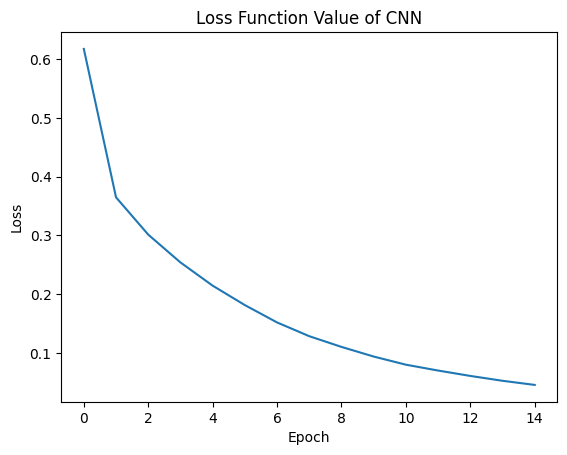

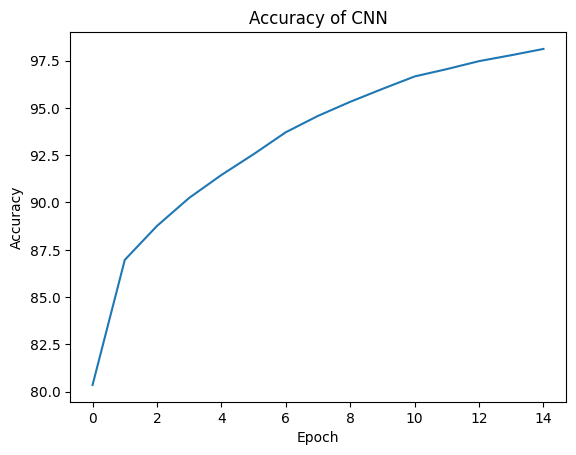

In [35]:
# plot loss function graph and accuracy graph
plot_graph(losses, accuracies, 'CNN')

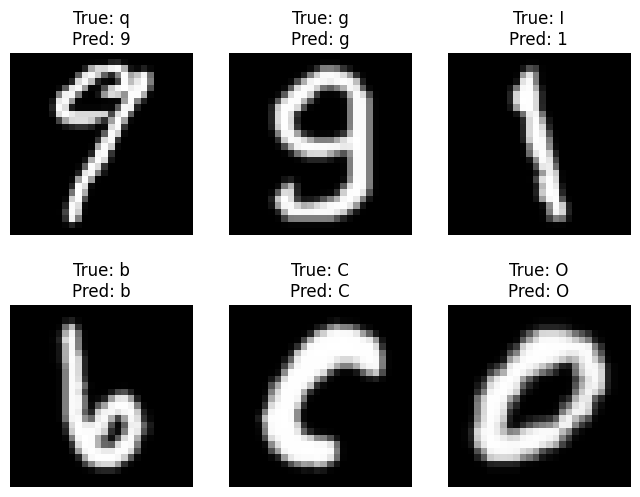

In [46]:
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=True)
images, labels = next(iter(test_loader))

# send the data to the GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
images = images.to(device)

# predict the labels using the CNN model
model.eval()
with torch.no_grad():
    outputs = model(images)
    _, predicted_labels = torch.max(outputs.data, 1)

# map class indices to class names
idx_to_class = {v: k for k, v in test_dataset.class_to_idx.items()}

# display the true and predicted labels for the top six samples
plt.figure(figsize=(8, 6))
for i in range(6):
    true_label = idx_to_class[labels[i].item()]
    predicted_label = idx_to_class[predicted_labels[i].item()]
    display_image(images[i], f"True: {true_label}\nPred: {predicted_label}", i + 1)

plt.show()

In [38]:
# get the result for generating the matrix and classification report
cm, true_labels, predicted_labels = generate_confusion_matrix_and_labels(model, test_loader)

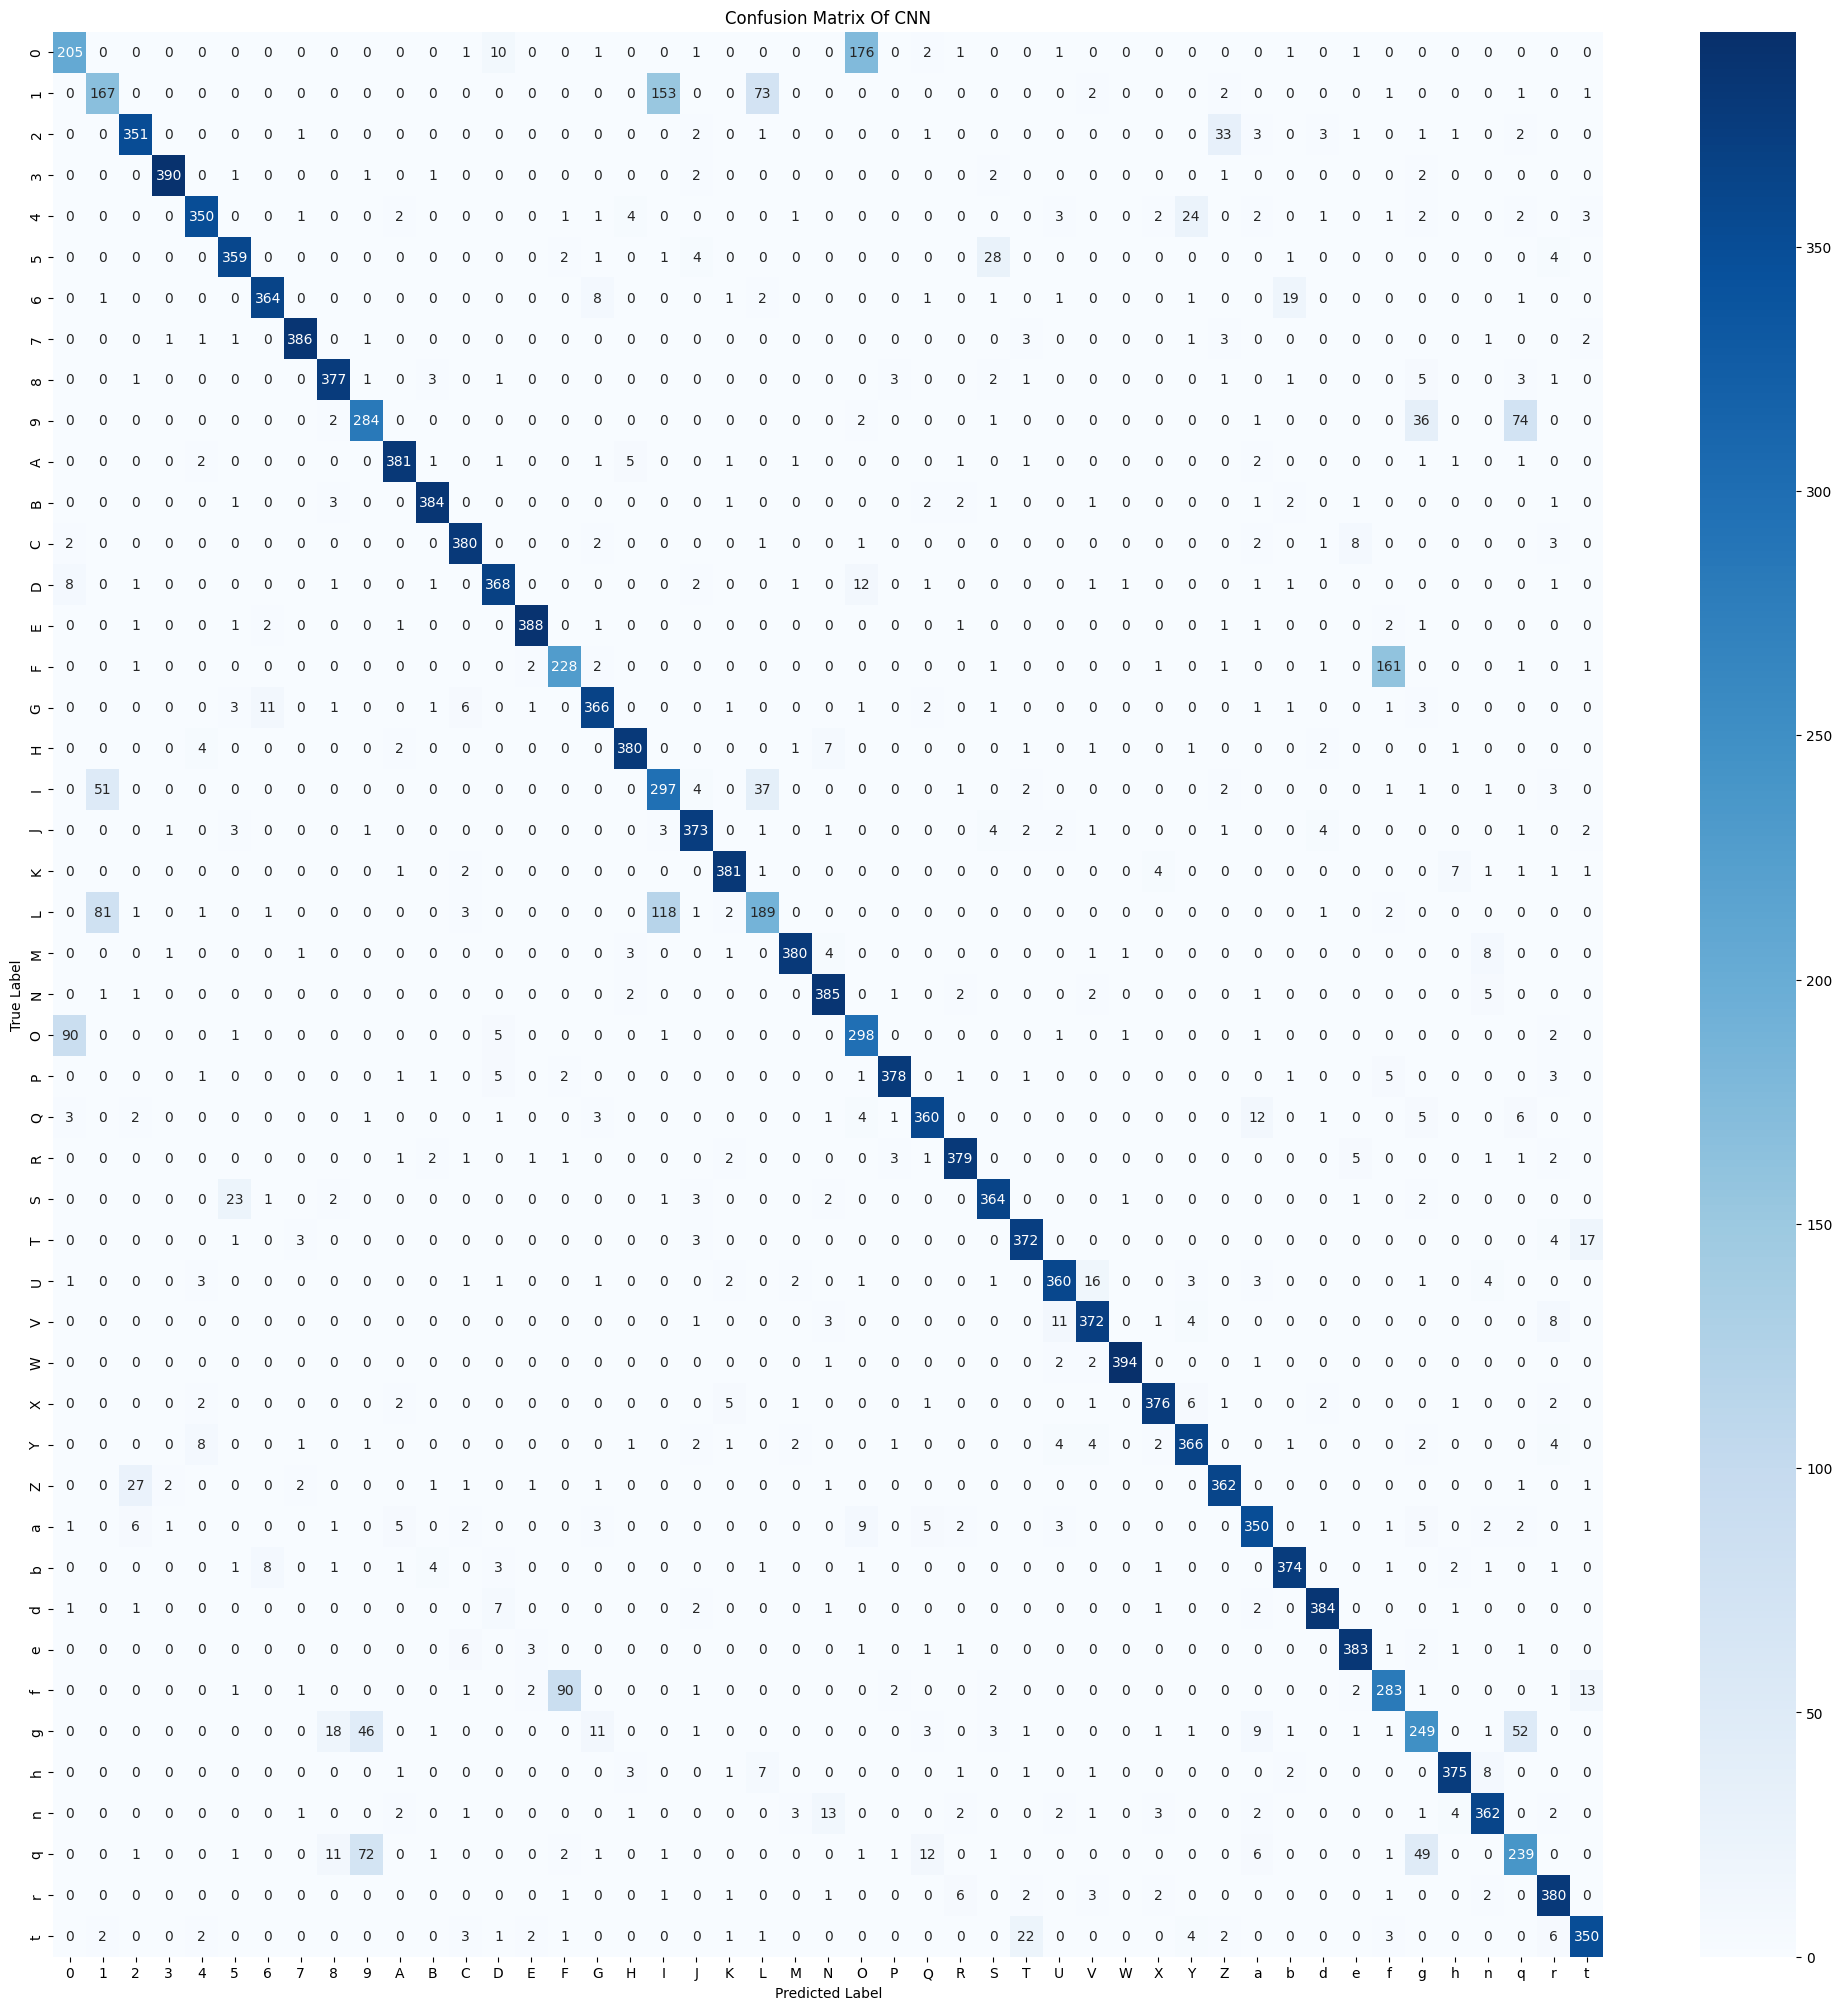

In [42]:
# plot confusion matrix
plot_confusion_matrix(cm, idx_to_class, 'CNN')

In [40]:
# generate the classification report
report = classification_report(true_labels, predicted_labels, target_names=idx_to_class.values())

# print the classification report od CNN model
print(report)

              precision    recall  f1-score   support

           0       0.66      0.51      0.58       400
           1       0.55      0.42      0.48       400
           2       0.89      0.88      0.88       400
           3       0.98      0.97      0.98       400
           4       0.94      0.88      0.90       400
           5       0.90      0.90      0.90       400
           6       0.94      0.91      0.93       400
           7       0.97      0.96      0.97       400
           8       0.90      0.94      0.92       400
           9       0.70      0.71      0.70       400
           A       0.95      0.95      0.95       400
           B       0.96      0.96      0.96       400
           C       0.93      0.95      0.94       400
           D       0.91      0.92      0.92       400
           E       0.97      0.97      0.97       400
           F       0.70      0.57      0.63       400
           G       0.91      0.92      0.91       400
           H       0.95    